[![Run Jupyter Notebooks](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/RichardPotthoff/Climate/main?filepath=LcapySim.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RichardPotthoff/Climate/blob/master/LcapySim.ipynb)

**Use electrical circuit simulation to simulate climate:**
- Electric current ~ Heat flow
- Capacitance ~ Heat capacity
- Electric resistance ~ Thermal resistance

In [1]:
import os
iPad='iPad' in os.uname().machine

try:
    import lcapy
except Exception as e:
    %pip install lcapy
    import lcapy
    if not iPad:
      !sudo apt-get install texlive-xetex
      !sudo apt-get install asymptote

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from lcapy import *
cct=Circuit(""" 
Isrc 2 0 {Isrc(s)};up,implicit
W 2 2_a;right
R1 2_a 0 4.05;up, implicit
W 2_a 2_b ;down=0.75
C1 2_b 0 0.75;right, implicit
R2 2_b 3 0.02;down
C2 3 0 1.25;right, implicit
R3 3 4 0.03;down
C3 4 0 2.  ;right, implicit
R4 4 5 0.075;down
C4 5 0 4.  ;right, implicit
R5 5 6 0.125;down
C5 6 0 6.  ;right, implicit
R6 6 7 0.20 ;down
C6 7 0 10.  ;right, implicit
R7 7 8 0.325;down
C7 8 0 16.  ;right, implicit 
R8 8 9 0.525;down
C8 9 0 26. ;right, implicit
;draw_nodes=connections, node_spacing=2, scale=0.75
""")
if iPad:
  cct.sch.draw('cct.tex')
  from IPython.display import IFrame
  display(IFrame('cct.pdf',550,400))
else:
  display(cct.sch.draw())

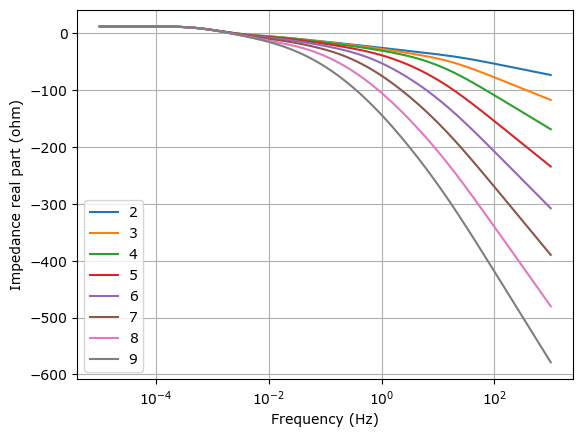

In [3]:
eit=np.linspace(0,10,1000)
V=cct[2].V(s)
Isrc=cct['Isrc'].I(s)
#R=V/Isrc

fv = np.logspace(-5, 3, 400)
ax=plt.gca()
for i in range(2,10):
  ((cct[i].V(s)/Isrc)(j2pif).dB).plot(fv, log_scale=True,unwrap=True,label=cct[i].name,axes=ax)  
plt.legend()
plt.show()

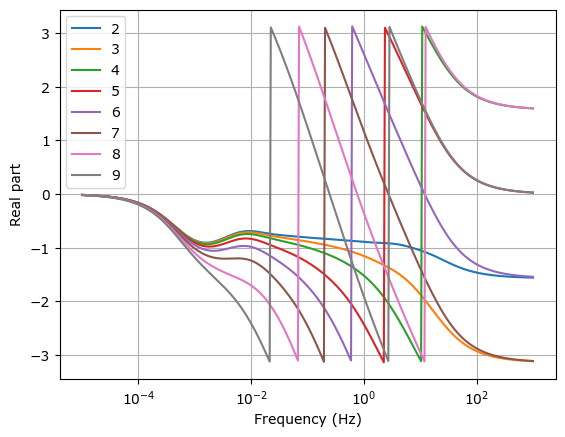

In [4]:
eit=np.linspace(0,10,1000)
V=cct[2].V(s)
Isrc=cct['Isrc'].I(s)
#R=V/Isrc

fv = np.logspace(-5, 3, 400)
ax=plt.gca()
for i in range(2,10):
  ((cct[i].V(s)/Isrc)(j2pif).phase).plot(fv, log_scale=True,unwrap=True,label=cct[i].name,axes=ax)  
plt.legend()
plt.show()

In [5]:
def a_b_sunrise(doy=80,lat=40.6,tilt=23.4):
  from math import sin, cos, pi, acos
  d2=(-sin(tilt/180*pi)**2*cos((doy - 80)/365*2*pi)**2 + 1)
  d=d2**0.5 if d2>0.0 else 1.0# prevent 0/0 error 
  a=cos(lat/180*pi)*cos(tilt/180*pi)/d
  b=sin(lat/180*pi)*sin(tilt/180*pi)*sin((doy - 80)/365*2*pi)/d
  cos_sunrise=b/a
  if cos_sunrise>=1:
    sunrise=0
  elif cos_sunrise<=-1:
    sunrise=pi
  else:
    sunrise=acos(b/a)
  return a,b,sunrise

In [6]:
def coeffi(a,b,delta,i):
  from math import sin,pi
  if i>=2:
    return(a*(sin((i-1)*delta)/(i-1)+sin((i+1)*delta)/(i+1))-2*b*sin(i*delta)/i)/pi
  elif i==0:
    return (a*sin(delta) - b*delta)/pi + b
  elif i==1:
    return (a*(2*delta + sin(2*delta))/2 - 2*b*sin(delta))/pi - a
  else:
    raise Exception(f'Invalid value for argument i: {i=}')
a,b,delta=a_b_sunrise(doy=80+365*0.25,lat=40.6,tilt=23.4)
#for i in range(40):
#    print(coeffi(a,b,delta,i))
c=[coeffi(a,b,delta,i) for i in range(10)]
from lcapy import t,cos
Fc1=[ci*cos(i*t) if i!=0 else ci*t**0 for i,ci in enumerate(c)]


/var/mobile/Containers/Data/Application/EAF35E54-A410-45E0-8A3B-8BF0692FEA2F/Library/lib/python3.11/site-packages/lcapy/ratfun.py:34: UserWarning: Cannot find symbolic roots for polynomial of degree 10, see Abel-Ruffini theorem
  warn('Cannot find symbolic roots for polynomial of degree %d, see Abel-Ruffini theorem' % poly.degree())
/var/mobile/Containers/Data/Application/EAF35E54-A410-45E0-8A3B-8BF0692FEA2F/Library/lib/python3.11/site-packages/lcapy/ratfun.py:42: UserWarning: Only 2 of 10 roots found, using numerical approximation
  warn('Only %d of %d roots found, using numerical approximation' %


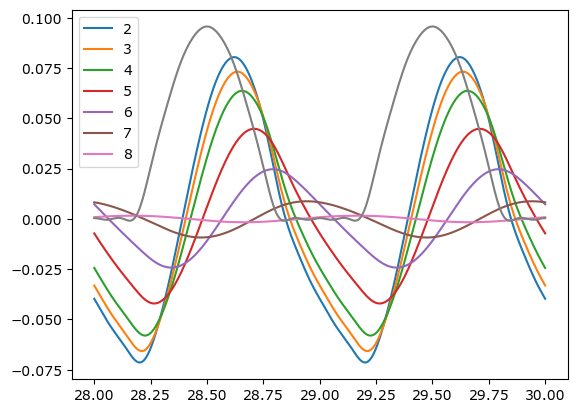

In [7]:
from matplotlib import pyplot as plt
import numpy as np 
ax=plt.gca()
vt = np.linspace(28, 30, 2000)
#V_0='0.25'
#cct1=cct.initialize({f'C{i:0d}':V_0 for i in range(1,9)},0)
#display(cct)
for i in range(2,9):
  VFci=np.array([(current(term(s))*(cct[i].V(s)/Isrc))(t).evaluate(vt*2*np.pi) for term in Fc1[1:]])
  plt.plot(vt,np.sum(VFci,axis=0),label=str(i))
plt.plot(vt,0.1*sum(Fc1[0:]).evaluate(vt*2*np.pi))
plt.legend()
plt.show()